In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [50]:
import utils
import numpy as np
import os
import v_net
from keras.utils import plot_model
import keras.backend as K
import importlib
importlib.reload(utils)
importlib.reload(v_net)

import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger
from utils import generalised_dice_loss, generalised_dice_loss_2, dice_coef_foreground, dice_coef, dice_coef_foreground_loss, dice_coef_background

In [51]:
target_dim = (128,128,32)
crop = (100,100)
bs=1
aug = utils.Scan_DataAugmenter(contrast_prob=0, affine_prob=0, shift_prob=0, rotation_prob=0, flip_prob=0, zoom_prob = 0)
# filters=([16,32,64,128,256],[32,64,128,256,512])
filters=([16,32,64,128], [32,64,128,256])
# loss = dice_coef_foreground_loss
loss = generalised_dice_loss_2

train_range = np.arange(0,209)
test_range = np.arange(209,221)

In [52]:
aug = utils.Scan_DataAugmenter(contrast_prob=0, affine_prob=0, shift_prob=0, rotation_prob=0, flip_prob=1, zoom_prob = 0)
gen_train = utils.Scan_DataGenerator('../ventricle_size_prediction/scans.h5', train_range, data_augmentor=None, batch_size=bs, target_dim=target_dim, crop=crop, shuffle=True, yc=2)
gen_valid = utils.Scan_DataGenerator('../ventricle_size_prediction/scans.h5', test_range, data_augmentor=None, batch_size=1, target_dim=target_dim, crop=crop, shuffle=False, yc=2)

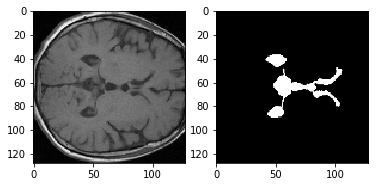

In [53]:
# Example data:
example = gen_train[100]
fig, a = plt.subplots(1,2)
a[0].imshow(example[0][0,:,:,20,0],cmap='gray')
a[1].imshow(example[1][0,:,:,20,1],cmap='gray',vmin=0, vmax=1)


In [63]:
# model = v_net.v_net(target_dim, activation='prelu', filters=filters[0])
model = v_net.v_net_shallow(target_dim, activation='prelu', filters=filters[1])
plot_model(model)
# for l in model.layers:
#    print (l.output_shape)

In [64]:
model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
Input (InputLayer)                     (None, 128, 128, 32, 1)    0                                                     
________________________________________________________________________________________________________________________
resblock_0_c0 (Conv3D)                 (None, 128, 128, 32, 32)   2432          Input[0][0]                             
________________________________________________________________________________________________________________________
add_51 (Add)                           (None, 128, 128, 32, 32)   0             Input[0][0]                             
                                                                                resblock_0_c0[0][0]                     
________________________________

In [66]:
model.compile(optimizer=Adam(lr=0.00001), loss=loss, metrics=['accuracy',dice_coef_foreground,dice_coef_background])
# model.compile(optimizer=Adam(lr=0.0001), loss=generalised_dice_loss, metrics=['accuracy',dice_coef])

In [67]:
model_checkpoint = ModelCheckpoint('v_net_NB.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
csv_logger = CSVLogger('training_vnet_NB.log')

In [68]:
import warnings
warnings.filterwarnings("ignore")
import importlib
importlib.reload(utils)

<module 'utils' from '/home/rmonti/MRI_data_Machine_Learning/vseg/utils.py'>

In [ ]:
model.fit_generator(gen_train, validation_data=gen_valid, epochs=25, verbose=1, callbacks=[model_checkpoint,csv_logger],max_queue_size=10, workers=8, use_multiprocessing=True)

Epoch 1/25
209/209 [==============================] - 238s 1s/step - loss: 0.6894 - acc: 0.7651 - dice_coef_foreground: 0.3056 - dice_coef_background: 0.8372 - val_loss: 0.5356 - val_acc: 0.9909 - val_dice_coef_foreground: 0.4561 - val_dice_coef_background: 0.9951

Epoch 00001: val_loss improved from inf to 0.53564, saving model to v_net_NB.hdf5
Epoch 2/25
209/209 [==============================] - 231s 1s/step - loss: 0.4199 - acc: 0.9891 - dice_coef_foreground: 0.5740 - dice_coef_background: 0.9941 - val_loss: 0.3460 - val_acc: 0.9927 - val_dice_coef_foreground: 0.6497 - val_dice_coef_background: 0.9961

Epoch 00002: val_loss improved from 0.53564 to 0.34602, saving model to v_net_NB.hdf5
Epoch 3/25
130/209 [=================>............] - ETA: 1:25 - loss: 0.3574 - acc: 0.9907 - dice_coef_foreground: 0.6374 - dice_coef_background: 0.9951